In [1]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

import os
import sys
import copy 
import pickle
import warnings

from astropy.cosmology import FlatLambdaCDM
from astropy.table import Table, Column, vstack, join

import numpy as np 

import matplotlib.pyplot as plt
from matplotlib import rcParams

import cluster_toolkit as ct

/Users/song/Dropbox/work/code/cluster_toolkit/cluster_toolkit/concentration.py:32: SyntaxWarning: "is" with a literal. Did you mean "=="?
  if Mass_type is "mean":
/Users/song/Dropbox/work/code/cluster_toolkit/cluster_toolkit/concentration.py:34: SyntaxWarning: "is" with a literal. Did you mean "=="?
  elif Mass_type is "crit":


In [3]:
#Starting from a power spectrum
#These can come from CAMB or CLASS or CCL or anything else
#They must be in units of Mpc/h comoving (standard for boltzmann codes)

klin = np.loadtxt("test_data/klin.txt")
Plin = np.loadtxt("test_data/plin.txt") #linear power spectrum

knl = np.loadtxt("test_data/knl.txt")
Pnl = np.loadtxt("test_data/pnl.txt") #nonlinear power spectrum

In [2]:
Mass = 1e14 #Msun/h
Omega_m = 0.3 #Masses are all defined with respect to rho_m

#NFW concentration
conc = 5

#Einasto parameters
rs = 1.0 #Scale radius
a = 0.19 #Einasto exponent

# Radii of the profiles
Nr = 1000
r = np.logspace(-2, 3, Nr) #3D distance, Mpc/h comoving

In [24]:
power_spectra = {
    'k_linear': klin, 'p_linear': Plin,
    'k_non_linear': knl, 'p_non_linear': Pnl
}

In [27]:
def get_cluster_dsigma(power_spectra, mass, conc, omega_m=0.3, n_r=1000,
                       r_p=np.logspace(-2, 2.4, 1000)):
    """Get the DeltaSigma profile of a cluster."""
    #3D distance, Mpc/h comoving
    r = np.logspace(-2, 3, n_r) 
    
    # One-halo is NFW and the Two-halo term is based off the matter correlation function
    xi_nfw = ct.xi.xi_nfw_at_r(r, mass, conc, omega_m)
    xi_mm = ct.xi.xi_mm_at_r(
        r, power_spectra['k_non_linear'], power_spectra['p_non_linear'])

    # Calculate the halo bias for this halo
    bias = ct.bias.bias_at_M(
        mass, power_spectra['k_linear'], power_spectra['p_linear'], omega_m)

    # Complete the 2-halo term
    xi_2halo = ct.xi.xi_2halo(bias, xi_mm)
    xi_hm = ct.xi.xi_hm(xi_nfw, xi_2halo)
    
    #Set up the projected radial separation
    sigma  = ct.deltasigma.Sigma_at_R(
        r_p, r, xi_hm, mass, conc, omega_m)
    
    # Delta sigma profile
    delta_sigma = ct.deltasigma.DeltaSigma_at_R(
        r_p, r_p, sigma, mass, conc, omega_m)
    
    return delta_sigma

### Correlation functions

In [9]:
# 1-halo is NFW and the 2-halo term is based off the matter correlation function
xi_nfw = ct.xi.xi_nfw_at_r(r, Mass, conc, Omega_m)
xi_mm = ct.xi.xi_mm_at_r(r, knl, Pnl)

# Calculate the halo bias for this halo
bias = ct.bias.bias_at_M(Mass, klin, Plin, Omega_m)

# Complete the 2-halo term
xi_2halo = ct.xi.xi_2halo(bias, xi_mm)
xi_hm = ct.xi.xi_hm(xi_nfw, xi_2halo)

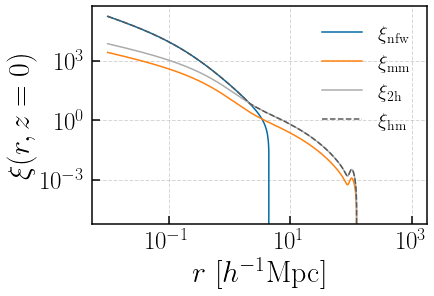

In [12]:
plt.loglog(r, xi_nfw,   label=r"$\xi_{\rm nfw}$")
plt.loglog(r, xi_mm,    label=r"$\xi_{\rm mm}$")
plt.loglog(r, xi_2halo, label=r"$\xi_{\rm 2h}$")
plt.loglog(r, xi_hm, ls='--', label=r"$\xi_{\rm hm}$")
plt.xlabel(r"$r\ [h^{-1}{\rm Mpc}]$", fontsize=30)
plt.ylabel(r"$\xi(r, z=0)$", fontsize=30)
plt.legend(frameon=False, fontsize=20)

In [14]:
#Set up the projected radial separation
Rp = np.logspace(-2, 2.4, Nr) #Mpc/h comoving

Sigma  = ct.deltasigma.Sigma_at_R(Rp, r, xi_hm, Mass, conc, Omega_m)
Sigma_nfw = ct.deltasigma.Sigma_nfw_at_R(Rp, Mass, conc, Omega_m)

Rmis = 0.02 #Mpc/h; the miscentering length
Sigma_g2d  = ct.miscentering.Sigma_mis_at_R(Rp, Rp, Sigma, Mass, conc, Omega_m, Rmis)
Sigma_exp  = ct.miscentering.Sigma_mis_at_R(Rp, Rp, Sigma, Mass, conc, Omega_m, Rmis, kernel="gamma")
Sigma_single  = ct.miscentering.Sigma_mis_single_at_R(Rp, Rp, Sigma, Mass, conc, Omega_m, Rmis)

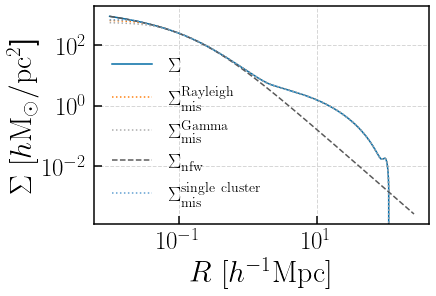

In [15]:
plt.loglog(Rp, Sigma, ls="-", label=r"$\Sigma$")
plt.loglog(Rp, Sigma_g2d, ls=":", label=r"$\Sigma_{\rm mis}^{\rm Rayleigh}$")
plt.loglog(Rp, Sigma_exp, ls=":", label=r"$\Sigma_{\rm mis}^{\rm Gamma}$")
plt.loglog(Rp, Sigma_nfw, ls="--", label=r"$\Sigma_{\rm nfw}$")
plt.loglog(Rp, Sigma_single, ls=":", label=r"$\Sigma_{\rm mis}^{\rm single\ cluster}$")

plt.ylabel(r"$\Sigma\ [h{\rm M_\odot/pc^2}$]", fontsize=30)
plt.xlabel(r"$R\ [h^{-1}{\rm Mpc}]$", fontsize=30)

plt.legend(frameon=False, fontsize=20)

In [16]:
DeltaSigma = ct.deltasigma.DeltaSigma_at_R(Rp, Rp, Sigma, Mass, conc, Omega_m)
DeltaSigma_nfw = ct.deltasigma.DeltaSigma_at_R(Rp, Rp, Sigma_nfw, Mass, conc, Omega_m)
DeltaSigma_g2d = ct.miscentering.DeltaSigma_mis_at_R(Rp, Rp, Sigma_g2d)
DeltaSigma_exp = ct.miscentering.DeltaSigma_mis_at_R(Rp, Rp, Sigma_exp)
DeltaSigma_single = ct.miscentering.DeltaSigma_mis_at_R(Rp, Rp, Sigma_single)

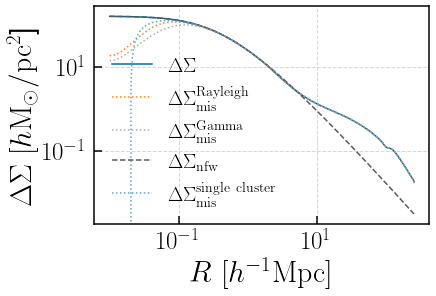

In [17]:
plt.loglog(Rp, DeltaSigma, ls="-", label=r"$\Delta\Sigma$")
plt.loglog(Rp, DeltaSigma_g2d, ls=":", label=r"$\Delta\Sigma_{\rm mis}^{\rm Rayleigh}$")
plt.loglog(Rp, DeltaSigma_exp, ls=":", label=r"$\Delta\Sigma_{\rm mis}^{\rm Gamma}$")
plt.loglog(Rp, DeltaSigma_nfw, ls="--", label=r"$\Delta\Sigma_{\rm nfw}$")
plt.loglog(Rp, DeltaSigma_single, ls=":", label=r"$\Delta\Sigma_{\rm mis}^{\rm single\ cluster}$")

plt.xlabel(r"$R\ [h^{-1}{\rm Mpc}]$", fontsize=30)
plt.ylabel(r"$\Delta\Sigma\ [h{\rm M_\odot/pc^2}$]", fontsize=30)

plt.legend(frameon=False, fontsize=20)

In [21]:
DeltaSigma = ct.deltasigma.DeltaSigma_at_R(Rp, Rp, Sigma, Mass, conc, Omega_m)

Redges = np.logspace(np.log10(0.05), np.log10(50.), num=13)
midpoints = (Redges[:-1] + Redges[1:])/2

average_DS = ct.averaging.average_profile_in_bins(Redges, Rp, DeltaSigma)

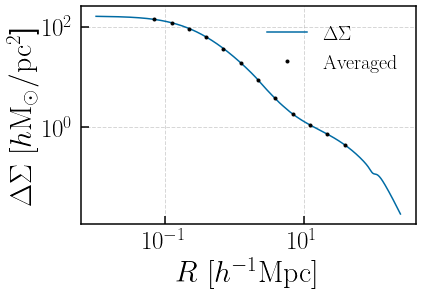

In [22]:
plt.loglog(Rp, DeltaSigma, ls="-", label=r"$\Delta\Sigma$")
plt.loglog(midpoints, average_DS, marker='.', ls='', c='k', label=r"$\rm Averaged$")

plt.xlabel(r"$R\ [h^{-1}{\rm Mpc}]$", fontsize=30)
plt.ylabel(r"$\Delta\Sigma\ [h{\rm M_\odot/pc^2}$]", fontsize=30)

plt.legend(frameon=False, fontsize=20)

In [28]:
r_p=np.logspace(-2, 2.4, 1000)

ds_1 = get_cluster_dsigma(power_spectra, 1e14, 5, omega_m=0.3, n_r=1000)
ds_2 = get_cluster_dsigma(power_spectra, 1e14, 10, omega_m=0.3, n_r=1000)

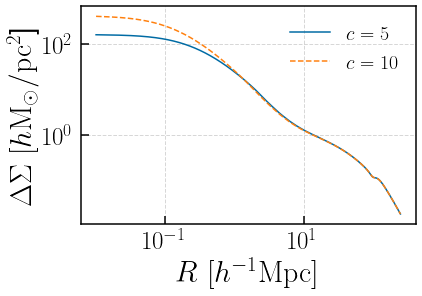

In [30]:
plt.loglog(r_p, ds_1, ls="-", label=r"$c=5$")
plt.loglog(r_p, ds_2, ls="--", label=r"$c=10$")

plt.xlabel(r"$R\ [h^{-1}{\rm Mpc}]$", fontsize=30)
plt.ylabel(r"$\Delta\Sigma\ [h{\rm M_\odot/pc^2}$]", fontsize=30)

plt.legend(frameon=False, fontsize=20)